In [1]:
# change dir so that delsmm is the root dir
import os
os.chdir('..')

In [68]:
# imports 
%load_ext autoreload
%autoreload 2

from delsmm.plotutils.dpen_viz import dpen_viz

import torch
from ceem import utils
from torch.utils.data import TensorDataset
import numpy as np

from delsmm.systems.lag_doublepen import LagrangianDoublePendulum

from tqdm import tqdm
import matplotlib.pyplot as plt

from delsmm.utils import kalman_smooth_and_diff

from delsmm.smm import StructuredMechanicalModel
from delsmm.barriercrit import LogDetBarrierCriterion
from delsmm.lagcrit import DELCriterion
from ceem.opt_criteria import GroupCriterion

from torch.utils.data import TensorDataset, DataLoader

from torch.nn.utils import parameters_to_vector as ptv
from torch.nn.utils import vector_to_parameters as vtp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
# simulate some double pendulum data

utils.set_rng_seed(2)

torch.set_default_dtype(torch.float64)

dt = 0.05
qdim = 2
sys = LagrangianDoublePendulum(dt, 1.,1.,1.,1.,10.)

q1 = torch.rand(1,1,2) * np.pi - np.pi/2
q2 = q1.clone()

qs = [q1, q2]

for t in range(200):
    qt = qs[-2].detach()
    qtp1 = qs[-1].detach()

    nq = sys.variational_step(qt,qtp1)
    qs.append(nq)

q = torch.cat(qs, dim=1).detach()

qpert = q + torch.randn_like(q) * 0.01

B, T, _ = q.shape
t = torch.arange(T).unsqueeze(0).repeat(B,1).float() 

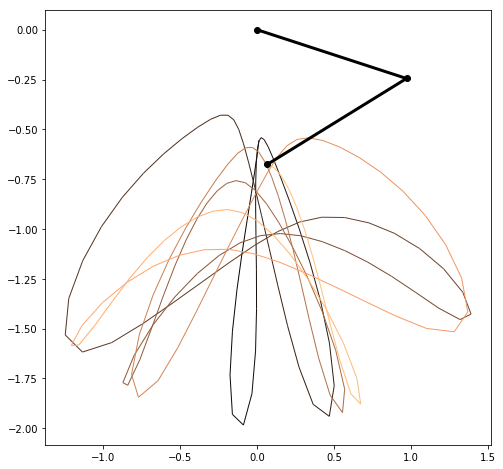

In [74]:
plt.figure(figsize=(8,8))
ax = plt.gca()

dpen_viz(ax,q,1.,1.)

In [75]:
# smooth the noisy observations of q using Kalman smoothing
smq, smdq, smddq = kalman_smooth_and_diff(qpert,dt)

100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


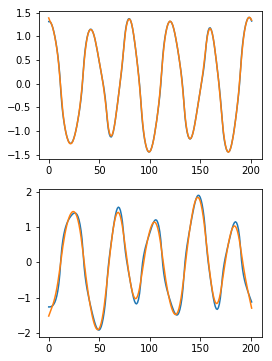

In [76]:
plt.figure(figsize=(4,6))
plt.subplot(2,1,1)
plt.plot(q[0,:,0])
plt.plot(smq[0,:,0])

plt.subplot(2,1,2)
plt.plot(q[0,:,1])
plt.plot(smq[0,:,1])

plt.show()

In [77]:
# fit an SMM to smq by minimizing the DEL residual

# create the dataloader

smq_1 = smq[:,:-2]
smq_2 = smq[:,1:-1]
smq_3 = smq[:,2:]
smq_B = torch.stack([smq_1,smq_2,smq_3], dim=2).reshape(-1,3,2).detach()
dataset = TensorDataset(smq_B)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)


torch.manual_seed(1)
system = StructuredMechanicalModel(qdim=qdim, dt=dt)
dyncrit = DELCriterion(t)

# initialize the barrier criterion, and find an appropriate coefficient between it and DELcrit
lb = LogDetBarrierCriterion.mineig(system, smq).detach() * 0.99 # interior point init

barriercrit = LogDetBarrierCriterion(lb)

# find an appropriate mu
with torch.no_grad():
    dyncritloss = dyncrit(system, smq)
    barriercritloss = barriercrit(system, smq)

    mu = float(dyncritloss / barriercritloss) # mu makes them ~equal at init

barriercrit = LogDetBarrierCriterion(lb, mu=mu, x_override=smq)

crit = GroupCriterion([dyncrit, barriercrit])

# setup optimizer, scheduler
opt = torch.optim.Adam(system.parameters(), lr = 1e-2)
sched = torch.optim.lr_scheduler.LambdaLR(opt, lambda k: 50./(50+k))

next_params = ptv(system.parameters()).detach()

In [78]:
# train

# train with SGD
for epoch in range(500):

    for batch in dataloader:

        prev_params = next_params

        opt.zero_grad()

        loss = crit(system, *batch)

        loss.backward()

        opt.step()

        # check line search
        n_ls  = 0

        while True:

            next_params = ptv(system.parameters()).detach()

            del_params = next_params - prev_params

            with torch.no_grad():
                c = crit(system, smq)

            if torch.isnan(c):
                next_params = prev_params + 0.5 * del_params
                vtp(next_params, system.parameters())

                n_ls += 1
            else:
                break
    
    sched.step()
            
    if epoch % 100 == 0:
        print('Epoch %d, Loss %.3e' % (epoch, float(loss)))


Epoch 0, Loss 1.339e+04
Epoch 100, Loss -5.760e+05
Epoch 200, Loss -5.874e+05
Epoch 300, Loss -5.915e+05
Epoch 400, Loss -6.023e+05


In [79]:
# simulate learned system
q1 = q[:,0:1]
q2 = q[:,1:2]

q_ = 0.5 * (q1+q2)
qdot = (q2-q1)/dt

x = torch.cat([q_,qdot],dim=-1)
xs = [x]

with torch.no_grad():
    for t in tqdm(range(T+1)):
        xs.append(system.step(torch.zeros(1,1).float(), xs[-1]))

xs = torch.cat(xs, dim=1)
qsim = xs[...,:qdim].detach()

100%|██████████| 203/203 [00:02<00:00, 85.63it/s]


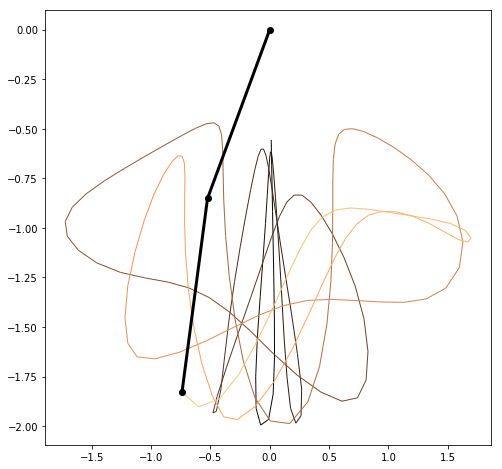

In [80]:
plt.figure(figsize=(8,8))
ax = plt.gca()

dpen_viz(ax,qsim,1.,1.)